In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.regularizers import L1, L2
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [2]:
df = pd.read_csv(r"C:\Users\danfe\OneDrive\Desktop\School_Work\MATH 6373\Project\emotion_sentiment_dataset.csv")
df = df.drop(df.columns[0], axis = 1)
df = df.drop_duplicates()
df.head()

,text,Emotion
0,i seriously hate one subject to death but now ...,hate
1,im so full of life i feel appalled,neutral
2,i sit here to write i start to dig out my feel...,neutral
3,ive been really angry with r and i feel like a...,anger
4,i feel suspicious if there is no one outside l...,neutral


In [3]:
df

,text,Emotion
0,i seriously hate one subject to death but now ...,hate
1,im so full of life i feel appalled,neutral
2,i sit here to write i start to dig out my feel...,neutral
3,ive been really angry with r and i feel like a...,anger
4,i feel suspicious if there is no one outside l...,neutral
...,...,...
422740,i cry and feel a sense of loss when my patient...,neutral
422741,i feel like telling these horny devils to find...,neutral
422743,i feel very curious be why previous early dawn...,neutral
422744,i feel that becuase of the tyranical nature of...,neutral


In [4]:
print(f"Unique emotions: {df['Emotion'].unique()}\n Number of unique emotions: {df['Emotion'].nunique()}")

Unique emotions: ['hate' 'neutral' 'anger' 'love' 'worry' 'relief' 'happiness' 'fun'
 'empty' 'enthusiasm' 'sadness' 'surprise' 'boredom']
 Number of unique emotions: 13


We need to convert our labels into numeric values so the model can work with them

In [5]:
df['Label'], Emotions = pd.factorize(df['Emotion'])

In [6]:
X = df['text']
y = df['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=37)

Before we can feed our inputs into the model, we need to convert them into a form the computer can read: numbers. Tensorflow has a tokenizer method built in, which essentially creates a dictionary of words from a series of texts.

Once we have all of our tokens, we can transform our lines of text into sequences of tokens which can be fed into the model.

In [7]:
tokenizer = Tokenizer(num_words = 60000, oov_token = "<OOV>")
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

Our model expects a uniform input size. To accomplish this we pad the sequences with 0's so that each input is equal in size to our largest input.

In [8]:
maxlen = max(len(tokens) for tokens in X_train_sequences)
print("Maximum sequence length (maxlen):", maxlen)

X_train_padded = pad_sequences(X_train_sequences, maxlen=maxlen, padding='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=maxlen, padding='post')

Maximum sequence length (maxlen): 178


In [9]:
np.max(X_train_padded) + 1

60000

In [10]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1) 

  return tf.cast(pos_encoding, dtype=tf.float32)
    
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True) 
    self.pos_encoding = positional_encoding(length=178, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

In [11]:
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = Sequential(
            [Dense(ff_dim, activation="relu"),
             Dense(embed_dim),]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [12]:
model = Sequential()
model.add(Input(shape=(maxlen,),dtype='float64'))
model.add(PositionalEmbedding(vocab_size = np.max(X_train_padded) + 1, d_model = 100))
model.add(TransformerBlock(embed_dim = 100, num_heads = 2, ff_dim = 64))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu',
                kernel_regularizer=L1(0.01),
                activity_regularizer=L2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(13, activation='softmax'))

In [13]:
# Now compile and summarize your model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 positional_embedding (Posit  (None, 178, 100)         6000000   
 ionalEmbedding)                                                 
                                                                 
 transformer_block (Transfor  (None, 178, 100)         94064     
 merBlock)                                                       
                                                                 
 global_average_pooling1d (G  (None, 100)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                6464      
                                                        

In [14]:
history = model.fit(X_train_padded, y_train, epochs=5, batch_size=32,
                    validation_data=(X_test_padded, y_test))

Epoch 1/5
9846/9846 [==============================] - 160s 16ms/step - loss: 0.4362 - accuracy: 0.9474 - val_loss: 0.1868 - val_accuracy: 0.9937
Epoch 2/5
9846/9846 [==============================] - 159s 16ms/step - loss: 0.2255 - accuracy: 0.9789 - val_loss: 0.1929 - val_accuracy: 0.9965
Epoch 3/5
9846/9846 [==============================] - 159s 16ms/step - loss: 0.2069 - accuracy: 0.9834 - val_loss: 0.1715 - val_accuracy: 0.9971
Epoch 4/5
9846/9846 [==============================] - 161s 16ms/step - loss: 0.1976 - accuracy: 0.9861 - val_loss: 0.1447 - val_accuracy: 0.9977
Epoch 5/5
9846/9846 [==============================] - 178s 18ms/step - loss: 0.1890 - accuracy: 0.9883 - val_loss: 0.1382 - val_accuracy: 0.9980


In [15]:
history_dict = history.history
json.dump(history_dict, open('transformer_history','w'))

In [16]:
model.save('Transformer_Model')

INFO:tensorflow:Assets written to: Transformer_Model\assets


INFO:tensorflow:Assets written to: Transformer_Model\assets
C:\Users\danfe\anaconda3\envs\Tensor_gpu\lib\site-packages\keras\engine\sequential.py:454: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_configs.append(generic_utils.serialize_keras_object(layer))
C:\Users\danfe\anaconda3\envs\Tensor_gpu\lib\site-packages\keras\saving\saved_model\layer_serialization.py:134: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [9]:
model = tf.keras.models.load_model(r"C:\Users\danfe\OneDrive\Desktop\School_Work\MATH 6373\Project\Transformer\Transformer_Model")

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 178, 100)          6000000   
                                                                 
 transformer_block (Transfor  (None, 178, 100)         94064     
 merBlock)                                                       
                                                                 
 global_average_pooling1d (G  (None, 100)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                6464      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0

In [18]:
history = json.load(open(r"C:\Users\danfe\OneDrive\Desktop\School_Work\MATH 6373\Project\Transformer\transformer_history",'r'))

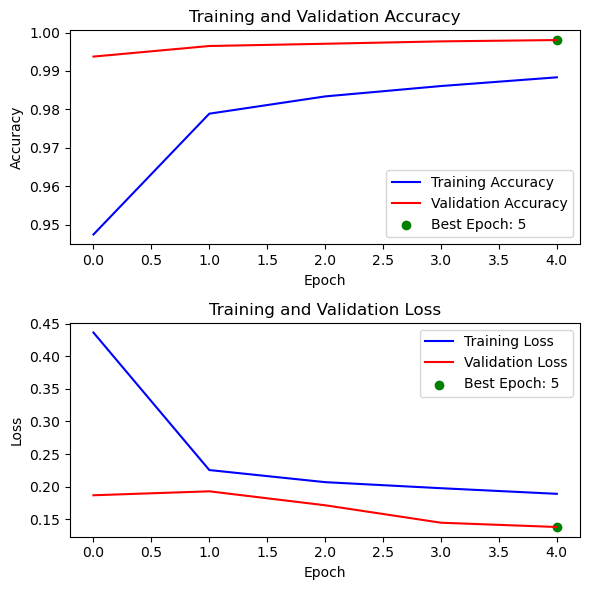

In [19]:
best_epoch = history['val_accuracy'].index(max(history['val_accuracy'])) + 1

fig, axs = plt.subplots(2, 1, figsize=(6, 6))

# Plot training and validation accuracy
axs[0].plot(history['accuracy'], label='Training Accuracy', color='blue')
axs[0].plot(history['val_accuracy'], label='Validation Accuracy', color='red')
axs[0].scatter(best_epoch - 1, history['val_accuracy'][best_epoch - 1], color='green', label=f'Best Epoch: {best_epoch}')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Training and Validation Accuracy')
axs[0].legend()

# Plot training and validation loss
axs[1].plot(history['loss'], label='Training Loss', color='blue')
axs[1].plot(history['val_loss'], label='Validation Loss', color='red')
axs[1].scatter(best_epoch - 1, history['val_loss'][best_epoch - 1], color='green',label=f'Best Epoch: {best_epoch}')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Training and Validation Loss')
axs[1].legend()

plt.tight_layout()
plt.show()

In [20]:
y_pred = model.predict(X_test_padded)
y_pred = np.argmax(y_pred, axis=1)

2462/2462 [==============================] - 12s 5ms/step


In [21]:
print(classification_report(y_test,y_pred,labels = list(np.arange(13)),target_names = ['hate', 'neutral', 'anger', 'love', 'worry', 'relief', 'happiness', 'fun',
 'empty', 'enthusiasm', 'sadness', 'surprise', 'boredom'], zero_division = 0.0))

              precision    recall  f1-score   support

        hate       1.00      0.99      1.00      1206
     neutral       1.00      1.00      1.00     63386
       anger       0.99      0.99      0.99      1189
        love       1.00      0.99      1.00      3541
       worry       1.00      0.99      0.99       413
      relief       0.99      0.99      0.99      1606
   happiness       1.00      0.99      1.00      2621
         fun       1.00      0.99      0.99       946
       empty       0.99      0.98      0.99       534
  enthusiasm       1.00      0.99      1.00       867
     sadness       1.00      0.99      0.99      1768
    surprise       0.99      1.00      0.99       672
     boredom       0.00      0.00      0.00        16

    accuracy                           1.00     78765
   macro avg       0.92      0.91      0.92     78765
weighted avg       1.00      1.00      1.00     78765



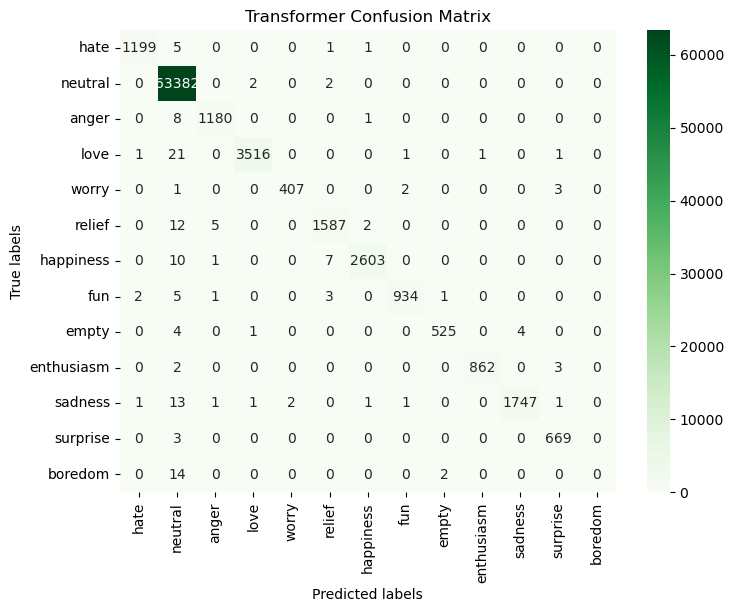

In [22]:
# y_test and y_pred are your true and predicted labels
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot = True, fmt='d', cmap = 'Greens',
           xticklabels = ['hate', 'neutral', 'anger', 'love', 'worry', 'relief', 'happiness', 'fun',
 'empty', 'enthusiasm', 'sadness', 'surprise', 'boredom'],
           yticklabels = ['hate', 'neutral', 'anger', 'love', 'worry', 'relief', 'happiness', 'fun',
 'empty', 'enthusiasm', 'sadness', 'surprise', 'boredom']) 
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Transformer Confusion Matrix')
plt.show()

### Generative Model

In [4]:
songs = pd.read_csv(r"C:\Users\danfe\OneDrive\Desktop\School_Work\MATH 6373\Project\Song Data\lyrics-data.csv")
songs_en = songs[songs.language == 'en']
songs_en = songs_en[:250]

In [5]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(songs_en['Lyric'].astype(str).str.lower())

total_words = len(tokenizer.word_index)+1
tokenized_sentences = tokenizer.texts_to_sequences(songs_en['Lyric'].astype(str))
tokenized_sentences[0]

[2,
 63,
 22,
 2952,
 149,
 2,
 62,
 15,
 318,
 7,
 868,
 1,
 5,
 3,
 228,
 264,
 149,
 3,
 479,
 2953,
 208,
 12,
 15,
 165,
 1326,
 5,
 133,
 9,
 2954,
 1327,
 7,
 18,
 480,
 1007,
 2955,
 10,
 53,
 124,
 228,
 200,
 1520,
 614,
 107,
 35,
 29,
 1008,
 517,
 36,
 438,
 5,
 680,
 2,
 27,
 40,
 61,
 9,
 467,
 1328,
 681,
 201,
 153,
 5,
 1329,
 9,
 417,
 7,
 615,
 3,
 939,
 14,
 112,
 76,
 869,
 22,
 10,
 53,
 124,
 228,
 200,
 3,
 65,
 2,
 1330,
 31,
 1,
 55,
 38,
 53,
 2956,
 3,
 2957,
 2958,
 26,
 9,
 84,
 417,
 5,
 3,
 157,
 7,
 133,
 2959,
 30,
 382,
 219,
 29,
 1331,
 12,
 3,
 518,
 368,
 30,
 18,
 151,
 158,
 10,
 53,
 124,
 228,
 200,
 1520,
 614,
 107,
 35,
 29,
 1008,
 517,
 36,
 438,
 5,
 680,
 2,
 27,
 40,
 61,
 9,
 467,
 1328,
 681,
 201,
 153,
 5,
 1329,
 9,
 417,
 7,
 615,
 23,
 939,
 14,
 112,
 76,
 869,
 22,
 10,
 53,
 124,
 228,
 200,
 3,
 65,
 2,
 1330,
 31,
 1,
 53,
 202,
 15,
 11,
 88,
 3,
 479,
 519,
 22,
 940,
 2,
 409,
 14,
 24,
 126,
 285,
 23,
 2240,
 520,
 36

In [6]:
# Create n-gram sequences
input_sequences = list()
for i in tokenized_sentences:
    for t in range(1, len(i)):
        n_gram_sequence = i[:t+1]
        input_sequences.append(n_gram_sequence)
        
# Pre-padding
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

In [7]:
# Creating predictors and labels
X, labels = input_sequences[:,:-1],input_sequences[:,-1]
y = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [12]:
model = Sequential()
model.add(Embedding(input_dim=total_words, output_dim=100,input_length=max_sequence_len - 1))
model.add(TransformerBlock(embed_dim = 100, num_heads = 2, ff_dim = 64))
model.add(GlobalAveragePooling1D())
model.add(Dropout(0.2))
model.add(Dense(total_words, activation='softmax'))

In [15]:
model.compile(
    loss='categorical_crossentropy', 
    optimizer=tf.keras.optimizers.Adam(learning_rate=.01), 
    metrics=['accuracy']
    )
earlystop = EarlyStopping(monitor='loss', min_delta = 0, patience = 3, verbose = 0, mode='auto')

In [16]:
history = model.fit(X,y, epochs = 10, verbose = 1, callbacks = [earlystop])

Epoch 1/10
2972/2972 [==============================] - 310s 103ms/step - loss: 6.2141 - accuracy: 0.0473
Epoch 2/10
2972/2972 [==============================] - 308s 104ms/step - loss: 5.8552 - accuracy: 0.0564
Epoch 3/10
2972/2972 [==============================] - 308s 104ms/step - loss: 5.6226 - accuracy: 0.0631
Epoch 4/10
2972/2972 [==============================] - 305s 103ms/step - loss: 5.4442 - accuracy: 0.0676
Epoch 5/10
2972/2972 [==============================] - 304s 102ms/step - loss: 5.3066 - accuracy: 0.0692
Epoch 6/10
2972/2972 [==============================] - 303s 102ms/step - loss: 5.1944 - accuracy: 0.0734
Epoch 7/10
2972/2972 [==============================] - 306s 103ms/step - loss: 5.0997 - accuracy: 0.0745
Epoch 8/10
2972/2972 [==============================] - 304s 102ms/step - loss: 5.0244 - accuracy: 0.0761
Epoch 9/10
2972/2972 [==============================] - 309s 104ms/step - loss: 4.9555 - accuracy: 0.0777
Epoch 10/10
2972/2972 [=======================

In [21]:
def generate_lyrics(seed_text, next_words):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predictions = model.predict(token_list, verbose=0)
        choice = np.random.choice([1,2,3])
        # sort ascending and select from 3 highest probabilities
        predicted = np.argsort(predictions)[0][-choice]
        
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " " + output_word
    return seed_text

In [23]:
def generate_lyrics(seed_text, next_words):
    # Loop until desired length is reached
    for _ in range(next_words):

	# Convert the seed text to a token sequence
    	token_list = tokenizer.texts_to_sequences([seed_text])[0]

	# Pad the sequence
    	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	
	# Feed to the model and get the probabilities for each index
    	probabilities = model.predict(token_list, verbose=0)

	# Get the index with the highest probability
    	predicted = np.argmax(probabilities, axis=-1)[0]

	# Ignore if index is 0 because that is just the padding.
    	if predicted != 0:
		
		# Look up the word associated with the index. 
    		output_word = tokenizer.index_word[predicted]

		# Combine with the seed text
    		seed_text += " " + output_word

# Print the result	
    print(seed_text)

In [24]:
seed_text = "hello darkness my old friend"
generate_lyrics(seed_text, 10)

hello darkness my old friend the the the the the the the the the the
